In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the dataset
df = pd.read_csv('Fragrance Dataset - COM7022 - [4037].csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

print("\nDataset info:")
print(df.info())

print("\nMissing values:")
print(df.isnull().sum())

Dataset shape: (1000, 10)

First few rows:
            brand                                              title  \
0            Dior  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...   
1         AS SHOW  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...   
2       Unbranded                   HOGO BOSS cologne For Men 3.4 oz   
3  Giorgio Armani  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...   
4         Lattafa  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...   

              type   price priceWithCurrency  available  \
0    Eau de Parfum   84.99      US $84.99/ea       10.0   
1    Eau de Parfum  109.99        US $109.99        8.0   
2  Eau de Toilette  100.00        US $100.00       10.0   
3  Eau de Toilette     NaN      US $44.99/ea        2.0   
4       Fragrances   16.91         US $16.91        NaN   

                           availableText   sold                lastUpdated  \
0      More than 10 available / 116 sold  116.0  May 24, 2024 10:03:04 PDT   
1            

In [3]:
# Data Preprocessing and Cleaning
def preprocess_data(df):
    # Create a copy to avoid modifying original data
    data = df.copy()
    
    # Handle missing values in price column
    # Extract price from priceWithCurrency if price is missing
    mask = data['price'].isna()
    data.loc[mask, 'price'] = data.loc[mask, 'priceWithCurrency'].str.extract(r'([0-9]+\.?[0-9]*)').astype(float)
    
    # Fill remaining missing prices with median
    data['price'] = data['price'].fillna(data['price'].median())
    
    # Handle missing values in available column
    # Extract numeric values from availableText
    def extract_available(text):
        if pd.isna(text):
            return np.nan
        # Look for numbers in available text
        import re
        numbers = re.findall(r'\d+', str(text))
        if numbers:
            return int(numbers[0])
        # Handle "More than 10 available" cases
        if 'More than 10' in str(text):
            return 15  # Approximate as 15
        if 'Limited quantity' in str(text):
            return 5   # Approximate as 5
        if 'Last One' in str(text):
            return 1
        return np.nan
    
    mask = data['available'].isna()
    data.loc[mask, 'available'] = data.loc[mask, 'availableText'].apply(extract_available)
    
    # Fill remaining missing available with median
    data['available'] = data['available'].fillna(data['available'].median())
    
    # Clean brand names
    data['brand'] = data['brand'].str.strip().str.title()
    
    # Clean type column and create intensity mapping
    type_intensity = {
        'Parfum': 5, 'LE PARFUM': 5, 'le parfum': 5, 'PARFUM': 5, 'Parfum Intense': 5,
        'Eau de Parfum': 4, 'Eau De Parfum': 4, 'Eau de Parfum Intense': 4,
        'Eau de Toilette': 3, 'Eau De Toilette': 3, 'EDT': 3,
        'Eau de Cologne': 2, 'Eau De Cologne': 2, 'Cologne': 2,
        'Perfume': 2, 'Fragrances': 2, 'Fragrance & Perfume': 2,
        'Body Spray': 1, 'Aftershave': 1, 'Deodorant': 1, 'Unscented': 1,
        'Pheromone': 2, 'Concentrated Uncut Pure Body Oil': 1, 'Extrait De Parfum': 5
    }
    
    data['type_intensity'] = data['type'].map(type_intensity)
    # Fill missing type_intensity with median
    data['type_intensity'] = data['type_intensity'].fillna(data['type_intensity'].median())
    
    # Simplify location to country level
    def extract_country(location):
        if pd.isna(location):
            return 'Unknown'
        location_str = str(location).lower()
        if 'united states' in location_str or 'usa' in location_str:
            return 'USA'
        elif 'canada' in location_str:
            return 'Canada'
        elif 'china' in location_str or 'shanghai' in location_str or 'shenzhen' in location_str:
            return 'China'
        elif 'hong kong' in location_str:
            return 'Hong Kong'
        elif 'taiwan' in location_str:
            return 'Taiwan'
        else:
            return 'Other'
    
    data['country'] = data['itemLocation'].apply(extract_country)
    
    return data

# Apply preprocessing
df_clean = preprocess_data(df)

print("\nAfter preprocessing:")
print(f"Missing values in price: {df_clean['price'].isnull().sum()}")
print(f"Missing values in available: {df_clean['available'].isnull().sum()}")
print(f"Missing values in type_intensity: {df_clean['type_intensity'].isnull().sum()}")


After preprocessing:
Missing values in price: 0
Missing values in available: 0
Missing values in type_intensity: 0


In [4]:
# Feature Engineering
def create_features(df):
    data = df.copy()
    
    # 1. Popularity ratio (handling division by zero)
    data['popularity_ratio'] = data['sold'] / (data['available'] + 1)
    
    # 2. Log transformation for price
    data['log_price'] = np.log1p(data['price'])
    
    # 3. Brand frequency (how common is the brand in dataset)
    brand_counts = data['brand'].value_counts()
    data['brand_frequency'] = data['brand'].map(brand_counts)
    
    # 4. Price segments
    data['price_segment'] = pd.cut(data['price'], 
                                 bins=[0, 20, 50, 100, 200, float('inf')],
                                 labels=['Budget', 'Affordable', 'Mid-range', 'Premium', 'Luxury'])
    
    # 5. Sales efficiency (sold per unit price)
    data['sales_efficiency'] = data['sold'] / (data['price'] + 1)
    
    return data

df_features = create_features(df_clean)

print("\nFeature statistics:")
print(df_features[['price', 'available', 'sold', 'popularity_ratio', 'log_price', 'brand_frequency']].describe())


Feature statistics:
             price    available          sold  popularity_ratio    log_price  \
count  1000.000000  1000.000000    994.000000        994.000000  1000.000000   
mean     46.454130    29.552000    766.266600         64.058155     3.631130   
std      35.526072    93.791279   3200.971733        214.297493     0.672043   
min       3.000000     1.000000      1.000000          0.020000     1.386294   
25%      22.990000     5.000000     14.000000          1.500000     3.177637   
50%      35.710000    10.000000     49.500000          5.000000     3.603049   
75%      59.000000    10.000000    320.500000         19.706667     4.094345   
max     259.090000   950.000000  54052.000000       2436.800000     5.561028   

       brand_frequency  
count       999.000000  
mean         17.366366  
std          17.206744  
min           1.000000  
25%           4.000000  
50%          11.000000  
75%          32.000000  
max          60.000000  


In [5]:
# Prepare data for clustering
def prepare_clustering_data(df):
    # Select features for clustering
    features = ['price', 'sold', 'available', 'type_intensity', 'popularity_ratio', 
               'log_price', 'brand_frequency', 'sales_efficiency']
    
    clustering_data = df[features].copy()
    
    # Handle any remaining missing values
    imputer = SimpleImputer(strategy='median')
    clustering_data_imputed = pd.DataFrame(
        imputer.fit_transform(clustering_data),
        columns=clustering_data.columns,
        index=clustering_data.index
    )
    
    # Standardize the features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(clustering_data_imputed)
    
    return pd.DataFrame(scaled_data, columns=clustering_data.columns), scaler, clustering_data_imputed

X_scaled, scaler, X_original = prepare_clustering_data(df_features)

print(f"Clustering data shape: {X_scaled.shape}")

Clustering data shape: (1000, 8)


  File "C:\Users\aksha\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\aksha\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aksha\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
                        pass_fds, cwd, env,
                        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
                        gid, gids, uid, umask,
                        ^^^^^^^^^^^^^^^^^^^^^^
                        start_new_session, process_group)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\aksha\anaconda3\Lib\subprocess.

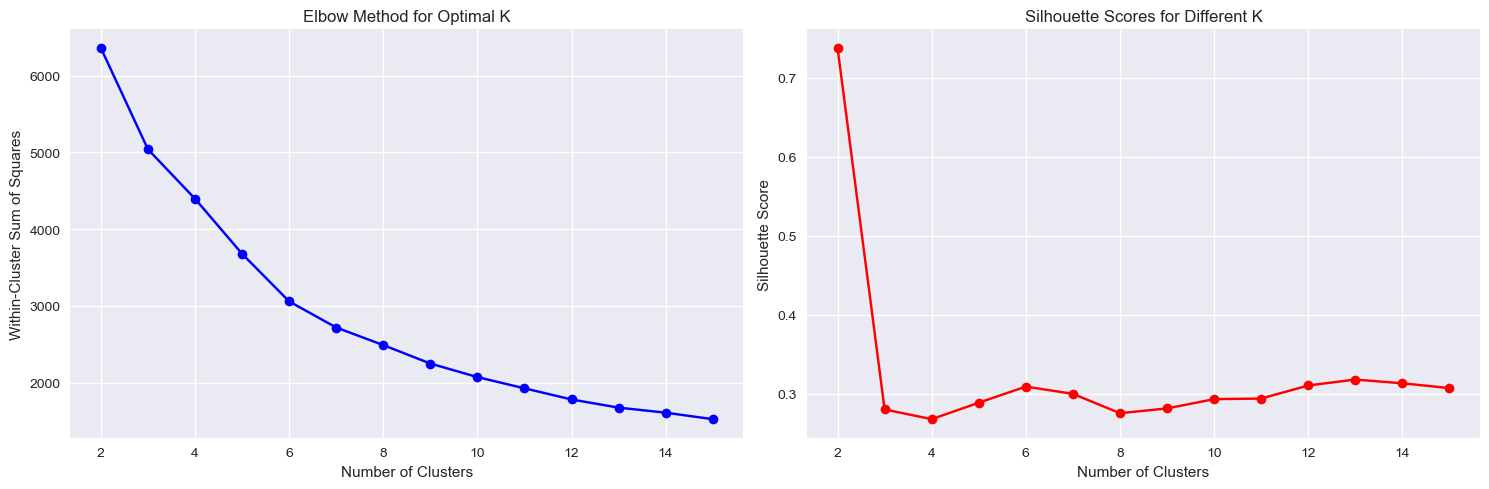

In [6]:
# Determine optimal number of clusters for K-Means
def find_optimal_clusters(X, max_k=15):
    wcss = []  # Within-cluster sum of squares
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
        
        if k > 1:  # Silhouette score requires at least 2 clusters
            silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    
    return wcss, silhouette_scores, k_range

wcss, silhouette_scores, k_range = find_optimal_clusters(X_scaled)

# Plot elbow curve and silhouette scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
ax1.plot(k_range, wcss, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Within-Cluster Sum of Squares')
ax1.set_title('Elbow Method for Optimal K')
ax1.grid(True)

# Silhouette scores
ax2.plot(range(2, len(silhouette_scores) + 2), silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Scores for Different K')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [7]:
# Apply different clustering algorithms
def apply_clustering(X, n_clusters=4):
    results = {}
    
    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X)
    results['KMeans'] = {
        'labels': kmeans_labels,
        'silhouette': silhouette_score(X, kmeans_labels),
        'davies_bouldin': davies_bouldin_score(X, kmeans_labels)
    }
    
    # Hierarchical Clustering
    hierarchical = AgglomerativeClustering(n_clusters=n_clusters)
    hierarchical_labels = hierarchical.fit_predict(X)
    results['Hierarchical'] = {
        'labels': hierarchical_labels,
        'silhouette': silhouette_score(X, hierarchical_labels),
        'davies_bouldin': davies_bouldin_score(X, hierarchical_labels)
    }
    
    # DBSCAN (automatically determines number of clusters)
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X)
    # Only calculate metrics if more than one cluster found
    unique_labels = np.unique(dbscan_labels)
    if len(unique_labels) > 1:
        results['DBSCAN'] = {
            'labels': dbscan_labels,
            'silhouette': silhouette_score(X, dbscan_labels),
            'davies_bouldin': davies_bouldin_score(X, dbscan_labels),
            'n_clusters': len(unique_labels) - (1 if -1 in unique_labels else 0)
        }
    else:
        results['DBSCAN'] = {
            'labels': dbscan_labels,
            'silhouette': 0,
            'davies_bouldin': float('inf'),
            'n_clusters': len(unique_labels) - (1 if -1 in unique_labels else 0)
        }
    
    return results

# Choose optimal number of clusters based on silhouette scores
optimal_k = np.argmax(silhouette_scores) + 2  # +2 because we started from k=2
print(f"Optimal number of clusters based on silhouette score: {optimal_k}")

clustering_results = apply_clustering(X_scaled, n_clusters=optimal_k)

# Print clustering performance
print("\nClustering Performance:")
print("=" * 50)
for method, result in clustering_results.items():
    if method == 'DBSCAN':
        print(f"{method}:")
        print(f"  Number of clusters: {result['n_clusters']}")
        print(f"  Silhouette Score: {result['silhouette']:.3f}")
        print(f"  Davies-Bouldin Index: {result['davies_bouldin']:.3f}")
    else:
        print(f"{method}:")
        print(f"  Silhouette Score: {result['silhouette']:.3f}")
        print(f"  Davies-Bouldin Index: {result['davies_bouldin']:.3f}")
    print("-" * 30)

# Use K-Means results for further analysis (usually performs well)
best_method = 'KMeans'  # You can change this based on performance metrics
final_labels = clustering_results[best_method]['labels']
df_features['cluster'] = final_labels

Optimal number of clusters based on silhouette score: 2

Clustering Performance:
KMeans:
  Silhouette Score: 0.738
  Davies-Bouldin Index: 0.716
------------------------------
Hierarchical:
  Silhouette Score: 0.530
  Davies-Bouldin Index: 1.158
------------------------------
DBSCAN:
  Number of clusters: 11
  Silhouette Score: 0.071
  Davies-Bouldin Index: 1.825
------------------------------


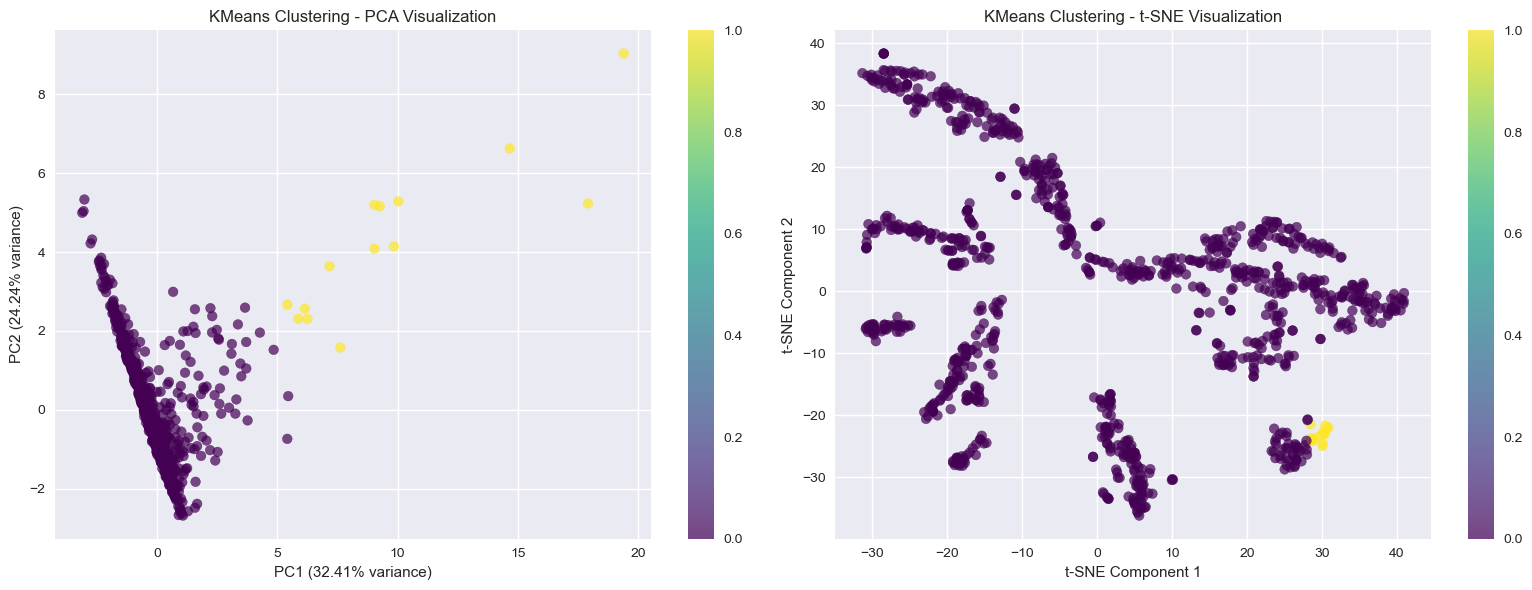


Cluster Analysis:
Cluster 0:
  Size: 986 (98.6%)
  Avg Price: $46.71
  Avg Sold: 454
  Avg Popularity Ratio: 47.27
  Avg Type Intensity: 3.2
  Top Brands: {'Giorgio Armani': 60, 'Paco Rabanne': 45, 'Ralph Lauren': 41, 'Unbranded': 39, 'Armaf': 34}
  Top Countries: {'USA': 922, 'Hong Kong': 32, 'Canada': 11}
----------------------------------------
Cluster 1:
  Size: 14 (1.4%)
  Avg Price: $28.72
  Avg Sold: 22430
  Avg Popularity Ratio: 1221.25
  Avg Type Intensity: 2.9
  Top Brands: {'Versace': 4, 'Davidoff': 2, 'Calvin Klein': 2, 'Azzaro': 1, 'C.K': 1}
  Top Countries: {'USA': 14}
----------------------------------------


In [10]:
# Dimensionality Reduction for Visualization
def visualize_clusters(X, labels, method_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # PCA Visualization
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X)
    
    scatter1 = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.7)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    ax1.set_title(f'{method_name} Clustering - PCA Visualization')
    plt.colorbar(scatter1, ax=ax1)
    
    # t-SNE Visualization
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_tsne = tsne.fit_transform(X)
    
    scatter2 = ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', alpha=0.7)
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    ax2.set_title(f'{method_name} Clustering - t-SNE Visualization')
    plt.colorbar(scatter2, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    
    return X_pca, X_tsne

X_pca, X_tsne = visualize_clusters(X_scaled, final_labels, best_method)

# Cluster Analysis
def analyze_clusters(df_with_clusters, original_features):
    cluster_analysis = {}
    
    for cluster_id in sorted(df_with_clusters['cluster'].unique()):
        cluster_data = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
        cluster_original = original_features[df_with_clusters['cluster'] == cluster_id]
        
        analysis = {
            'size': len(cluster_data),
            'percentage': len(cluster_data) / len(df_with_clusters) * 100,
            'avg_price': cluster_original['price'].mean(),
            'avg_sold': cluster_original['sold'].mean(),
            'avg_popularity_ratio': cluster_original['popularity_ratio'].mean(),
            'avg_type_intensity': cluster_original['type_intensity'].mean(),
            'common_brands': cluster_data['brand'].value_counts().head(5).to_dict(),
            'common_countries': cluster_data['country'].value_counts().head(3).to_dict(),
            'price_segments': cluster_data['price_segment'].value_counts().to_dict()
        }
        cluster_analysis[cluster_id] = analysis
    
    return cluster_analysis

cluster_analysis = analyze_clusters(df_features, X_original)

print("\nCluster Analysis:")
print("=" * 60)
for cluster_id, analysis in cluster_analysis.items():
    print(f"Cluster {cluster_id}:")
    print(f"  Size: {analysis['size']} ({analysis['percentage']:.1f}%)")
    print(f"  Avg Price: ${analysis['avg_price']:.2f}")
    print(f"  Avg Sold: {analysis['avg_sold']:.0f}")
    print(f"  Avg Popularity Ratio: {analysis['avg_popularity_ratio']:.2f}")
    print(f"  Avg Type Intensity: {analysis['avg_type_intensity']:.1f}")
    print(f"  Top Brands: {analysis['common_brands']}")
    print(f"  Top Countries: {analysis['common_countries']}")
    print("-" * 40)

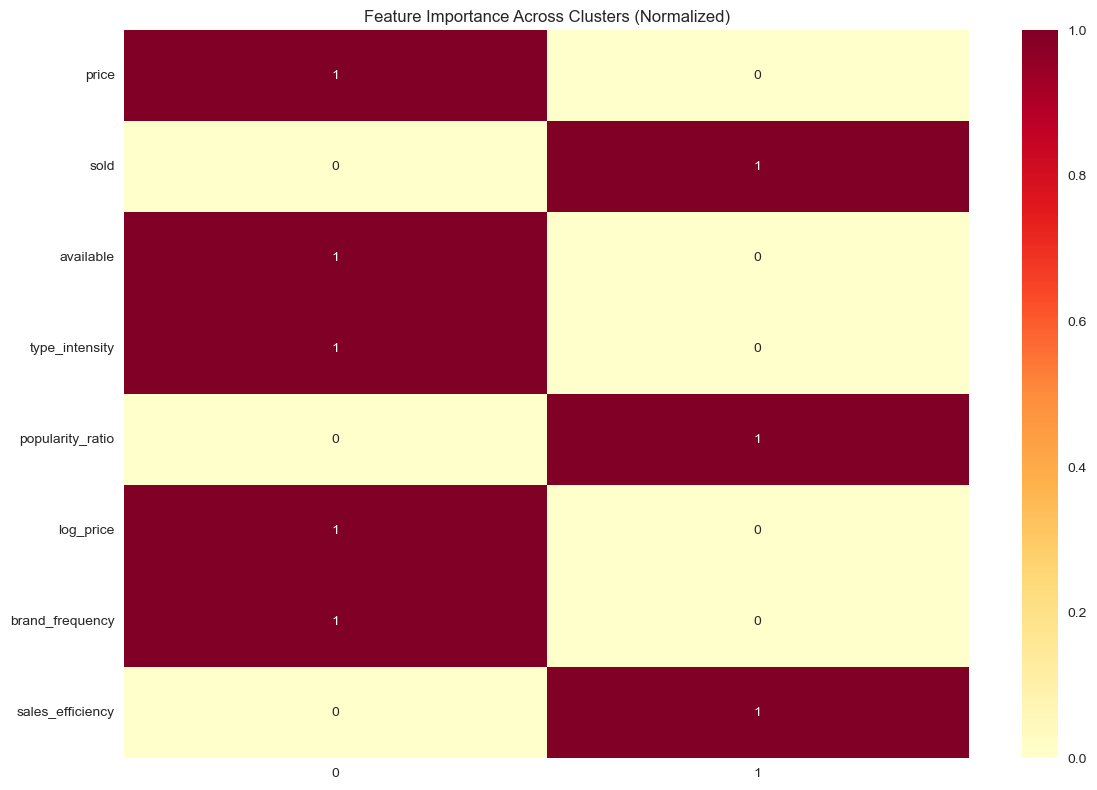

In [11]:
# Feature importance in clustering
def feature_importance_analysis(X_original, labels):
    # Calculate mean values for each feature per cluster
    feature_means = X_original.groupby(labels).mean()
    
    # Normalize to see relative importance
    feature_importance = (feature_means - feature_means.min()) / (feature_means.max() - feature_means.min())
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(feature_importance.T, annot=True, cmap='YlOrRd', center=0.5)
    plt.title('Feature Importance Across Clusters (Normalized)')
    plt.tight_layout()
    plt.show()
    
    return feature_importance

feature_importance = feature_importance_analysis(X_original, final_labels)

In [12]:
# Create comprehensive cluster profiles
def create_cluster_profiles(cluster_analysis):
    profiles = {}
    
    for cluster_id, analysis in cluster_analysis.items():
        # Determine cluster characteristics
        if analysis['avg_price'] < 30:
            price_category = "Budget"
        elif analysis['avg_price'] < 70:
            price_category = "Affordable"
        elif analysis['avg_price'] < 120:
            price_category = "Mid-range"
        else:
            price_category = "Premium/Luxury"
        
        if analysis['avg_popularity_ratio'] > 100:
            popularity = "High Demand"
        elif analysis['avg_popularity_ratio'] > 10:
            popularity = "Medium Demand"
        else:
            popularity = "Low Demand"
        
        if analysis['avg_type_intensity'] >= 4:
            intensity = "High Intensity (Parfum/EDP)"
        elif analysis['avg_type_intensity'] >= 3:
            intensity = "Medium Intensity (EDT)"
        else:
            intensity = "Low Intensity (Cologne/Spray)"
        
        profiles[cluster_id] = {
            'price_category': price_category,
            'popularity': popularity,
            'intensity': intensity,
            'description': f"{price_category} fragrances with {popularity.lower()} and {intensity.lower()}"
        }
    
    return profiles

cluster_profiles = create_cluster_profiles(cluster_analysis)

print("\nCluster Profiles:")
print("=" * 50)
for cluster_id, profile in cluster_profiles.items():
    print(f"Cluster {cluster_id}: {profile['description']}")

# Save the results
df_results = df_features[['brand', 'title', 'type', 'price', 'sold', 'available', 
                        'country', 'cluster', 'popularity_ratio', 'price_segment']].copy()

# Add cluster profiles
df_results['cluster_profile'] = df_results['cluster'].map(
    {k: v['description'] for k, v in cluster_profiles.items()}
)

print(f"\nFinal dataset with clusters saved. Shape: {df_results.shape}")
print("\nSample of clustered data:")
print(df_results.head(10))


Cluster Profiles:
Cluster 0: Affordable fragrances with medium demand and medium intensity (edt)
Cluster 1: Budget fragrances with high demand and low intensity (cologne/spray)

Final dataset with clusters saved. Shape: (1000, 11)

Sample of clustered data:
             brand                                              title  \
0             Dior  Christian Dior Sauvage Men's EDP 3.4 oz Fragra...   
1          As Show  A-v-entus Eau de Parfum 3.3 oz 100ML Millesime...   
2        Unbranded                   HOGO BOSS cologne For Men 3.4 oz   
3   Giorgio Armani  Acqua Di Gio by Giorgio Armani 6.7 Fl oz Eau D...   
4          Lattafa  Lattafa Men's Hayaati Al Maleky EDP Spray 3.4 ...   
5  Multiple Brands  Men's Perfume Sampler 10pcs Sample Vials Desig...   
6  Maison Alhambra  Glacier Bold by Maison Alhambra 3.4oz EDP for ...   
7        Unbranded  Parfums De-Marly-Haltane Eau de Parfum spray 4...   
8        Unbranded  Hawas for him Eau De Parfum By Rasasi 100ml 3....   
9          

In [ ]:

# Save to CSV
df_results.to_csv('fragrance_clusters_analysis.csv', index=False)
print("\nResults saved to 'fragrance_clusters_analysis.csv'")

# Additional visualizations
def additional_visualizations(df_with_clusters):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Cluster distribution
    cluster_counts = df_with_clusters['cluster'].value_counts().sort_index()
    axes[0,0].bar(cluster_counts.index, cluster_counts.values)
    axes[0,0].set_xlabel('Cluster')
    axes[0,0].set_ylabel('Number of Products')
    axes[0,0].set_title('Cluster Distribution')
    
    # 2. Average price by cluster
    price_by_cluster = df_with_clusters.groupby('cluster')['price'].mean()
    axes[0,1].bar(price_by_cluster.index, price_by_cluster.values)
    axes[0,1].set_xlabel('Cluster')
    axes[0,1].set_ylabel('Average Price ($)')
    axes[0,1].set_title('Average Price by Cluster')
    
    # 3. Popularity ratio by cluster
    popularity_by_cluster = df_with_clusters.groupby('cluster')['popularity_ratio'].mean()
    axes[1,0].bar(popularity_by_cluster.index, popularity_by_cluster.values)
    axes[1,0].set_xlabel('Cluster')
    axes[1,0].set_ylabel('Average Popularity Ratio')
    axes[1,0].set_title('Average Popularity Ratio by Cluster')
    
    # 4. Brand distribution in clusters
    brand_cluster_cross = pd.crosstab(df_with_clusters['brand'], df_with_clusters['cluster'])
    top_brands = brand_cluster_cross.sum(axis=1).nlargest(10).index
    brand_cluster_cross.loc[top_brands].plot(kind='bar', ax=axes[1,1], stacked=True)
    axes[1,1].set_xlabel('Brand')
    axes[1,1].set_ylabel('Number of Products')
    axes[1,1].set_title('Top 10 Brands Distribution Across Clusters')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

additional_visualizations(df_features)

print("\nClustering analysis completed successfully!")